In [1]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from keys import gemini_api_key
from langchain_huggingface import HuggingFaceEmbeddings

In [2]:
os.environ["GOOGLE_API_KEY"]= gemini_api_key
embeddings=HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')
llm= ChatGoogleGenerativeAI(model= "gemini-1.5-pro-latest")

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.schema import Document
from langchain.document_loaders import TextLoader

In [4]:
loader= TextLoader("color-psychology.txt")
data1= loader.load()

loader= TextLoader("natural-disasters.txt")
data2= loader.load()

In [5]:
docs= data1 + data2

## 1. Parent Document Retriever

Does similarity search on children chunks and returns the associated parent chunk. <br>Split data into two parts: parent chunks: large, children chunks: small<br> Smaller chunks have better accuracy for similarity search, while parent chunks retain more context.<br> 

In [15]:
from langchain.storage import InMemoryStore
from langchain.retrievers import ParentDocumentRetriever

In [17]:
child_splitter= RecursiveCharacterTextSplitter(chunk_size= 120, chunk_overlap= 20)
parent_splitter= RecursiveCharacterTextSplitter(chunk_size= 420, chunk_overlap= 20)

vectorstore= Chroma(collection_name= "full_documents", embedding_function= embeddings)
store= InMemoryStore()
retriever= ParentDocumentRetriever(
    vectorstore= vectorstore,
    docstore= store,
    child_splitter= child_splitter,
    parent_splitter= parent_splitter
)

In [19]:
retriever.add_documents(docs, ids= None)

In [21]:
vectorstore.similarity_search("both good and bad")

[Document(page_content='meanings, such as flat or boring.', metadata={'doc_id': '1ee50054-073e-4583-bc69-7776c331e72c', 'source': 'color-psychology.txt'}),
 Document(page_content='color of darkness or sadness.', metadata={'doc_id': 'e5338359-8ca2-4071-82cf-062f6fb0a6ea', 'source': 'color-psychology.txt'}),
 Document(page_content='1. Black', metadata={'doc_id': 'be629510-0d4e-4980-9c5f-9573b51792a3', 'source': 'color-psychology.txt'}),
 Document(page_content='1. Black', metadata={'doc_id': '02cf4f80-dc5c-4027-aaba-8fac1c4b229c', 'source': 'color-psychology.txt'})]

In [23]:
retriever.get_relevant_documents("both good and bad")

C:\Users\HP\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


[Document(page_content='The color white itself means clean, simple or holy. But on the other hand, white also has negative meanings, such as flat or boring.\n\n3. Red\n\nMoving on from black and white, red is a quite unique color, because red has good and bad meanings. For example, people will consider red as a color that shows anger, chaos, etc. However, red can also be interpreted as a color that shows strength, enthusiasm or love.', metadata={'source': 'color-psychology.txt'}),
 Document(page_content='So, what effect does black have on a personâ€™s psychology? What does the color black mean? Black gives a formal and exclusive impression. But on the other hand, black can also be interpreted as the color of darkness or sadness.\n\n2. White', metadata={'source': 'color-psychology.txt'}),
 Document(page_content='1. Black\n\nBlack is currently often used by most designers, whether creating designs for music or fitness groups. Not infrequently, people nowadays also prefer dark colors like

## 2. MultiQueryRetriever

use an llm to alter the question into many other ways, and use each question to retrieve the respective most similar chunk from the vector store. Now attach all these in to the prompt(as context) and send to an llm for output

In [26]:
from langchain.retrievers.multi_query import MultiQueryRetriever

In [28]:
retriever= MultiQueryRetriever.from_llm(
    retriever= vectorstore.as_retriever(),
    llm= llm
)

In [30]:
vector_docs= retriever.get_relevant_documents("both good and bad")

In [32]:
vector_docs

[Document(page_content='technological developments, and various other things related to design. Letâ€™s make this place a place for us to', metadata={'doc_id': '29d84cb4-4c5f-472c-8eb2-db5a99656026', 'source': 'color-psychology.txt'}),
 Document(page_content='and information about design that we need to know.', metadata={'doc_id': '29d84cb4-4c5f-472c-8eb2-db5a99656026', 'source': 'color-psychology.txt'}),
 Document(page_content='2. Wound infections â€” Open wounds can become infected by the dirty water, and itâ€™s easy to cut yourself on sharp', metadata={'doc_id': 'a92f766d-c772-4459-8cd6-489d6861fed8', 'source': 'natural-disasters.txt'}),
 Document(page_content='2. Injuries due to building damage â€” If a building is damaged during an earthquake, debris and other objects may fall', metadata={'doc_id': '0b20d220-486d-47e6-8aea-fb27405d7f06', 'source': 'natural-disasters.txt'}),
 Document(page_content='Risks and Injuries', metadata={'doc_id': '994c8685-c65e-495d-8020-dad68c97576e', 'so

## 3. Contextual Compression

use an llm to compress (summarize) the data after retrieving it from the vector store). Now attach all these in to the prompt(as context) and send to an llm for output

In [6]:
text_splitter= RecursiveCharacterTextSplitter(
    chunk_size= 100,
    chunk_overlap= 20,
    length_function= len,
    is_separator_regex = False
)
data= text_splitter.split_documents(docs)
vectorstore= Chroma(collection_name= "full_documents", embedding_function= embeddings)
retriever= vectorstore.as_retriever()
retriever.add_documents(data, ids= None);

In [21]:
retriever.get_relevant_documents(query= "both good and bad")

[Document(page_content='also has negative meanings, such as flat or boring.', metadata={'source': 'color-psychology.txt'}),
 Document(page_content='higher. When an earthquake has a magnitude of 6 or higher, itâ€™s considered extremely destructive.', metadata={'source': 'natural-disasters.txt'}),
 Document(page_content='black mean? Black gives a formal and exclusive impression. But on the other hand, black can also be', metadata={'source': 'color-psychology.txt'}),
 Document(page_content='1. Black', metadata={'source': 'color-psychology.txt'})]

In [23]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

compressor= LLMChainExtractor.from_llm(llm)
compression_retriever= ContextualCompressionRetriever(base_compressor= compressor, base_retriever= retriever)

compressed_docs= compression_retriever.get_relevant_documents(query= "both good and bad")

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


In [25]:
compressed_docs

[]

since we use llm for compression, it gets expensive, below is an alternative: (but we don't compress the data using llm here)

## 4. Embeddings Filter

documents are sent to embedding models, we can calculate similarity for each document w.r.t. the query

In [51]:
query= "both good and bad"

In [47]:
from langchain.retrievers.document_compressors import EmbeddingsFilter

In [61]:
embeddings_filter= EmbeddingsFilter(embeddings= embeddings, similarity_threshold= 0.6)
compression_filter= ContextualCompressionRetriever(base_compressor= embeddings_filter, base_retriever= retriever)

compressed_docs= compression_retriever.get_relevant_documents(query= query)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


In [63]:
compressed_docs

[]

## 5. Ensemble Retriever

use multiple retrievers, and combine the output of all

Sparse vectors are good at finding relevant documents based on keywords<BR>
whereas dense vectors, based on semantic similarity. Both of them complement each other

In [81]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
bm25_retriever= BM25Retriever.from_documents(data)
bm25_retriever.k= 2

chroma_vectorstore= Chroma.from_documents(data, embeddings)
chroma_retriever= chroma_vectorstore.as_retriever()

ensemble_retriever= EnsembleRetriever(
    retrievers= [bm25_retriever, chroma_retriever], weights= [0.5, 0.5]
)

In [83]:
results= ensemble_retriever.get_relevant_documents(query= query)
results

[Document(page_content='Risks and Injuries', metadata={'source': 'natural-disasters.txt'}),
 Document(page_content='Moving on from black and white, red is a quite unique color, because red has good and bad meanings.', metadata={'source': 'color-psychology.txt'}),
 Document(page_content='also has negative meanings, such as flat or boring.', metadata={'source': 'color-psychology.txt'}),
 Document(page_content='and bad meanings. For example, people will consider red as a color that shows anger, chaos, etc.', metadata={'source': 'color-psychology.txt'})]

## 6. Self Querying Retriever

uses the metadata of the documents based on the input query

In [11]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

In [23]:
text_splitter= RecursiveCharacterTextSplitter(
    chunk_size= 100,
    chunk_overlap= 20,
    length_function= len,
    is_separator_regex = False
)
data= text_splitter.split_documents(docs)

chroma_vectorstore= Chroma.from_documents(data, embeddings)
chroma_retriever= chroma_vectorstore.as_retriever()

metadata_field_info= [
    AttributeInfo(
        name= "source",
        description= "topic of the document",
        type= "string"
    )
]

document_content_description= "documents about color pyschology and natural disasters"
retriever= SelfQueryRetriever.from_llm(
    llm,
    chroma_vectorstore,
    document_content_description,
    metadata_field_info
)

In [31]:
retriever.invoke("individuals may associate the color black with feelings of distress") #i.e., .get_relevant_documents()

[Document(page_content='black can also be interpreted as the color of darkness or sadness.', metadata={'source': 'color-psychology.txt'}),
 Document(page_content='black can also be interpreted as the color of darkness or sadness.', metadata={'source': 'color-psychology.txt'}),
 Document(page_content='black can also be interpreted as the color of darkness or sadness.', metadata={'source': 'color-psychology.txt'}),
 Document(page_content='black can also be interpreted as the color of darkness or sadness.', metadata={'source': 'color-psychology.txt'})]

## 7. Time Weighted Vector Store

uses decay rate and metadata about the documents (time related such as last created, last edited etc..)
"High decay rate makes old documents invalidate fast, while low decay rate keeps them valid longer."

## 8. RAG fusion

- Generate multiple queries based on the given user query using an llm
- Perform vector searches for both the original and generated queries
- use reciprocal rank fusion to reorder the results

## 9. Two Stage Retrieval with Cross Encoder

  converting text to vector results in some loss of information, cross encoder performs better here

In [8]:
doc_strings= [i.page_content for i in data]

In [9]:
vectors= embeddings.embed_documents(doc_strings)

In [8]:
db= Chroma.from_documents(data, embeddings)
retriever= db.as_retriever(search_kwargs= {'k': 6})

In [11]:
from visualize_embeddings import visualizeEmbeddings

In [12]:
embeds= visualizeEmbeddings()

In [13]:
embeds.fit(vectors)

C:\Users\HP\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [14]:
global_embeddings= embeds.umap_embed(vectors)

100%|████████████████████████████████████████████████████████████████████████████████| 206/206 [07:11<00:00,  2.09s/it]


(-6.635483264923096,
 14.46119737625122,
 -2.4717871487140655,
 19.514524036645888)

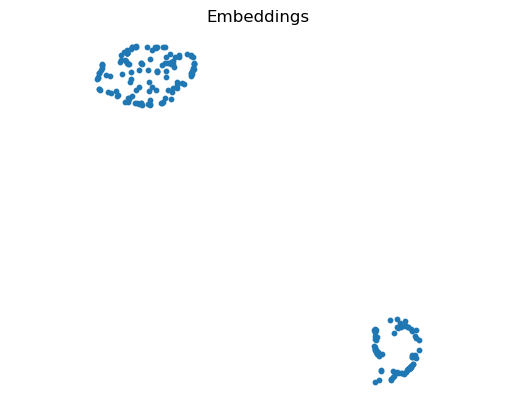

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Embeddings')
plt.axis('off')

C:\Users\HP\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.05s/it]


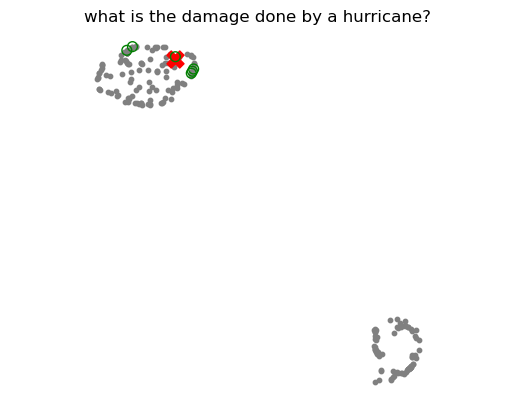

In [16]:
embeds.calc_global_embeddings("what is the damage done by a hurricane?", embeddings, retriever, global_embeddings)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.18s/it]


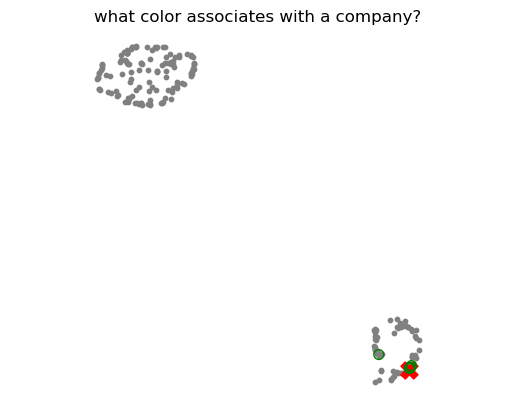

In [31]:
embeds.calc_global_embeddings("what color associates with a company?", embeddings, retriever, global_embeddings)

In [51]:
from langchain.chains import LLMChain
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

In [63]:
prompt_template= "Generate five different versions of the same given question. Do not give any explainations. Just straight to the point. \nQuery: {query}"
prompt= ChatPromptTemplate.from_template(prompt_template)

chain= prompt | llm | StrOutputParser()
result= chain.invoke({"query": "what color associates with a company?"})

In [64]:
result

"1. What color represents a company?\n2. What color embodies a company's identity?\n3. What color signifies a company's brand?\n4. What color do people associate with a company?\n5. What is a company's color? \n"

In [ ]:
result= result.split("\n")

In [73]:
result= result[:-1]

In [75]:
result

['1. What color represents a company?',
 "2. What color embodies a company's identity?",
 "3. What color signifies a company's brand?",
 '4. What color do people associate with a company?',
 "5. What is a company's color? "]

In [79]:
query= "what color associates with a company?"
docs= [retriever.get_relevant_documents(query) for query in result]

In [105]:
count=0
for i in docs:
    for j in i:
        count+=1
print(count)   #top k (6), for 5 questions

30


In [91]:
docs

[[Document(page_content='Colors and their meanings:', metadata={'source': 'color-psychology.txt'}),
  Document(page_content='Then, there is blue. The color blue itself is often used for companies, businesses, or designs', metadata={'source': 'color-psychology.txt'}),
  Document(page_content='1. Black', metadata={'source': 'color-psychology.txt'}),
  Document(page_content='a complement to the design or a balance between dark and bright colors.', metadata={'source': 'color-psychology.txt'}),
  Document(page_content='depending on what they are used for. So, what are the meanings of the colors that we often', metadata={'source': 'color-psychology.txt'}),
  Document(page_content='the combination of colors must of course suit the user.', metadata={'source': 'color-psychology.txt'})],
 [Document(page_content='This proves how influential a color is on a personâ€™s perception of something. Of course, knowing', metadata={'source': 'color-psychology.txt'}),
  Document(page_content='Colors and the

In [93]:
uniq_docs= set()
for i in docs:
    for j in i:
        uniq_docs.add(j.page_content)

In [95]:
len(uniq_docs)

15

In [107]:
uniq_docs

{'1. Black',
 '3. Red',
 '5. Blue',
 'Color Psychology â€” as previously discussed, the world of graphic design and color theory are',
 'Color psychology is also often used for marketing purposes. In the world of marketing, of course',
 'Colors and their meanings:',
 'Each color certainly has its own meaning and significance, even white and black also have their own',
 'How Color psychology works?',
 'Then, there is blue. The color blue itself is often used for companies, businesses, or designs',
 'This proves how influential a color is on a personâ€™s perception of something. Of course, knowing',
 'What is color psychology?',
 'a complement to the design or a balance between dark and bright colors.',
 'depending on what they are used for. So, what are the meanings of the colors that we often',
 'the combination of colors must of course suit the user.',
 'this, such as black, gold, gray or dark green. Of course, the combination of basic colors and'}

In [111]:
from sentence_transformers import CrossEncoder
cross_encoder= CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

pairs= []
for doc in uniq_docs:
    pairs.append([query, doc])

scores= cross_encoder.predict(pairs)

In [113]:
scored_docs= zip(scores, uniq_docs)
scored_docs= sorted(scored_docs, reverse= True)
scored_docs

[(0.48739782,
  'Then, there is blue. The color blue itself is often used for companies, businesses, or designs'),
 (-1.4796442, '3. Red'),
 (-1.5310198, '5. Blue'),
 (-2.3795652, '1. Black'),
 (-3.809833,
  'this, such as black, gold, gray or dark green. Of course, the combination of basic colors and'),
 (-6.018729,
  'a complement to the design or a balance between dark and bright colors.'),
 (-6.1652775,
  'Each color certainly has its own meaning and significance, even white and black also have their own'),
 (-7.3876233,
  'Color psychology is also often used for marketing purposes. In the world of marketing, of course'),
 (-8.301504, 'What is color psychology?'),
 (-8.383129, 'the combination of colors must of course suit the user.'),
 (-8.705719, 'Colors and their meanings:'),
 (-8.919555,
  'depending on what they are used for. So, what are the meanings of the colors that we often'),
 (-9.026719,
  'Color Psychology â€” as previously discussed, the world of graphic design and co

In [115]:
reranked_docs= [doc for _, doc in scored_docs][:5] #top 5

In [120]:
reranked_docs #these are the required documents.

['Then, there is blue. The color blue itself is often used for companies, businesses, or designs',
 '3. Red',
 '5. Blue',
 '1. Black',
 'this, such as black, gold, gray or dark green. Of course, the combination of basic colors and']

Lost in the middle problem:<br>
llms provide better accuracy when the important content is located at either the first or at the last. it doesnt perform well when it is in the middle.

In [123]:
from langchain_community.document_transformers import LongContextReorder

reordering= LongContextReorder()
reordered_docs= reordering.transform_documents(reranked_docs)
reordered_docs

['Then, there is blue. The color blue itself is often used for companies, businesses, or designs',
 '5. Blue',
 'this, such as black, gold, gray or dark green. Of course, the combination of basic colors and',
 '1. Black',
 '3. Red']

## 10. RAPTOR

**R**ecursive **A**bstractive **P**rocessing for **T**ree- **O**rganized **R**etrieval

Idea: Repeated clustering and summarizing chunks

In [19]:
#check no of tokens in all the documents (to see if it fits in the context window of the model

import tiktoken

def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

d_sorted = sorted(data, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 3725
